In [22]:
import itertools
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import numpy as np


In [23]:
search_root = "/checkpoint/jth/job_staging/neuraldb/"
files = glob.glob("{}*/*ndb*t5-base*/seed-*/metrics.json".format(search_root))
print(len(files))


0


In [21]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  return []

all_results = []
for file in files:
    if "experiment" in file:
        continue
    if "max_queries=null" not in file:
        continue

    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}

    with open(file) as f:
        try:
          metrics = json.load(f)
        except:
          print(f.readlines())
        if "validation" not in metrics or len(metrics['validation'])<95:
          continue

        epoch_em = [epoch["EM"] for epoch in metrics["validation"]]

        best_epoch_num = np.argmax(epoch_em)
        metrics = {"best_validation_epoch": metrics["validation"][best_epoch_num]["epoch"],
                   "best_validation_em": metrics["validation"][best_epoch_num]["EM"],
                   "best_validation_loss": metrics["validation"][best_epoch_num]["avg_val_loss"]
                  }

    data["context"] = int(data["context"])
    data["max_queries"] = int(data["max_queries"]) if data['max_queries'] != "null" else -1
    data.update(metrics)

    all_results.append(data)
print(len(all_results))
results = pd.DataFrame(all_results)


0


In [9]:
pd.set_option("display.max_rows", 500)
pt = pd.pivot_table(results, index=["model","context","lr"],columns=["version"],aggfunc={"best_validation_em":[np.mean,np.std]})
pt

best_validation_em                              
                                   mean                 std          
version                            v0.2      v0.4      v0.2      v0.4
model   context lr                                                   
t5-base 50      1e-2           0.512672  0.383339  0.049113  0.005843
                1e-3           0.985880  0.890296  0.003615  0.000938
                1e-4           0.987387  0.893356  0.000036  0.001065
                2e-3           0.973233  0.889164  0.007011  0.001617
                3e-4           0.991082  0.892965  0.001573  0.001257
                5e-3           0.678904  0.488616  0.125001  0.092259
                5e-4           0.991753  0.891933  0.001661  0.001219
                8e-3           0.535276  0.390270  0.014232  0.011977
                8e-4           0.989471  0.891317  0.002349  0.001254
        100     1e-2           0.433997  0.405221  0.011560  0.005351
                1e-3           0.989750  0.912900  0.001077  0.002454
                1e-4           0.992484  0.915241       NaN  0.002740
                2e-3           0.986724  0.909013  0.001175  0.001255
                3e-4           0.992236  0.915621  0.001271  0.001863
                5e-3           0.663424  0.593314  0.137743  0.112926
                5e-4           0.991893  0.914066  0.001315  0.001522
                8e-3           0.545022  0.413917  0.022435  0.007572
                8e-4           0.990969  0.913482  0.001470  0.000528
        300     1e-2           0.440616       NaN  0.016284       NaN
                1e-3           0.990921       NaN  0.001064       NaN
                1e-4           0.991610       NaN  0.000777       NaN
                2e-3           0.990801       NaN  0.000549       NaN
                3e-4           0.991292       NaN  0.000690       NaN
                5e-3           0.533788       NaN  0.023731       NaN
                5e-4           0.990912       NaN  0.000794       NaN
                8e-3           0.480537       NaN  0.029186       NaN
                8e-4           0.990318       NaN  0.001274       NaN
        500     1e-2           0.446265  0.429838  0.019445  0.016709
                1e-3           0.991625  0.937030  0.000020  0.001759
                1e-4                NaN  0.938547       NaN  0.002074
                2e-3           0.991616  0.931732  0.000439  0.003097
                3e-4                NaN  0.939458       NaN  0.002951
                5e-3           0.618420  0.622494  0.144000  0.116722
                5e-4                NaN  0.938452       NaN  0.002444
                8e-3           0.502379  0.445403  0.032608  0.021161
                8e-4                NaN  0.935264       NaN  0.001931
        1000    1e-2                NaN  0.406717       NaN  0.005299
                1e-3                NaN  0.931685       NaN  0.002713
                1e-4                NaN  0.933288       NaN  0.001682
                2e-3                NaN  0.925478       NaN  0.001820
                3e-4                NaN  0.931737       NaN  0.002033
                5e-3                NaN  0.578984       NaN  0.135764
                5e-4                NaN  0.932961       NaN  0.002299
                8e-3                NaN  0.409907       NaN  0.001494
                8e-4                NaN  0.931237       NaN  0.002257
        2000    1e-2                NaN  0.420074       NaN  0.003527
                1e-3                NaN  0.930454       NaN  0.001387
                1e-4                NaN  0.937100       NaN  0.003072
                2e-3                NaN  0.927761       NaN  0.005272
                3e-4                NaN  0.934029       NaN  0.005275
                5e-3                NaN  0.618834       NaN  0.137301
                5e-4                NaN  0.932807       NaN  0.001612
                8e-3                NaN  0.425873       NaN  0.008469
                8e-4           

In [15]:
original = {50: 49062,
  100: 44786,
  500: 37737,
  1000: 34474,
  2000: 30612,
  5000: 24410,
  7000: 22583,
  10000: 20246}

modified = {50: 48622,
  100: 44410,
  500: 37578,
  1000: 34382,
  2000: 30569,
  5000: 24392,
  7000: 22570,
  10000: 20238}

[0.9910317557376381, 0.9916045192694145, 0.9957866285078305, 0.9985953220959101, 0.99926259729619, 0.9994243457468007, 0.9996048602193026]


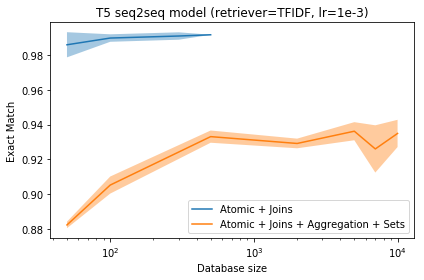

In [34]:

all_v2 = pt["best_validation_em"]["mean"]["v0.2"]["t5-base"]
all_v4 = pt["best_validation_em"]["mean"]["v0.4"]["t5-base"]

all_v2_std = pt["best_validation_em"]["std"]["v0.2"]["t5-base"]
all_v4_std = pt["best_validation_em"]["std"]["v0.4"]["t5-base"]

v2_datasets = [50,100,300,500]
v4_datasets = [50,100,500,2000,5000,7000,10000]

adj = [modified[data_size]/original[data_size]  for data_size in v4_datasets]
print(adj)


plt.title("T5 seq2seq model (retriever=TFIDF, lr=1e-3)")
plt.ylabel("Exact Match")
plt.xlabel("Database size")

v2_series = [all_v2[data_size]["1e-3"] for data_size in v2_datasets]
v4_series = [all_v4[data_size]["1e-3"]*a for a,data_size in zip(adj,v4_datasets)]

v2_l_series = [all_v2[data_size]["1e-3"]-2*all_v2_std[data_size]["1e-3"] for data_size in v2_datasets]
v4_l_series = [all_v4[data_size]["1e-3"]*a-2*all_v4_std[data_size]["1e-3"] for a,data_size in zip(adj,v4_datasets)]

v2_h_series = [all_v2[data_size]["1e-3"]+2*all_v2_std[data_size]["1e-3"] for data_size in v2_datasets]
v4_h_series = [all_v4[data_size]["1e-3"]*a+2*all_v4_std[data_size]["1e-3"] for a,data_size in zip(adj,v4_datasets)]

plt.plot(v2_datasets,v2_series)
plt.fill_between(v2_datasets, v2_l_series,v2_h_series, alpha=0.4)
plt.plot(v4_datasets,v4_series)
plt.fill_between(v4_datasets, v4_l_series,v4_h_series, alpha=0.4)

plt.xscale("log")

plt.legend(["Atomic + Joins", "Atomic + Joins + Aggregation + Sets"])

plt.tight_layout()
plt.savefig("/scratch/jth/neuraldb/t5_tfidf.pdf")
plt.show()


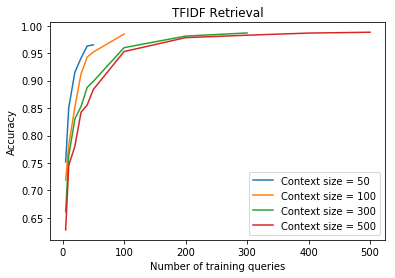

In [6]:
all_tfidf = pt["best_validation_accuracy"]["mean"]["tfidf"]["bert_cls"]

datasets = [50,100,300,500]

plt.title("TFIDF Retrieval")
plt.ylabel("Accuracy")
plt.xlabel("Number of training queries")

for data_size in datasets:
  plt.plot(all_tfidf[data_size][1:])

plt.legend(["Context size = {}" .format(data) for data in datasets])
plt.show()


In [39]:
print(pt)
all_bm25 = pt["best_validation_accuracy"]["mean"]["bm25"]["bert_cls"]
all_tfidf = pt["best_validation_accuracy"]["mean"]["tfidf"]["bert_cls"]

print(all_bm25)
plt.title("BERT Discriminative Model (v0.2) + Information Retrieval Baselines")
plt.ylabel("Accuracy")
plt.xlabel("Context Size")

datasets = [50,100,300,500]
plt.plot(datasets, [all_tfidf[ds][-1] for ds in datasets])
plt.plot(datasets, [all_bm25[ds][-1] for ds in datasets])

plt.legend(["TFIDF","BM25"])
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



                     best_validation_em                              
                                   mean                 std          
version                            v0.2      v0.4      v0.2      v0.4
model   context lr                                                   
t5-base 50      1e-2           0.512672  0.383339  0.049113  0.005843
                1e-3           0.985880  0.890296  0.003615  0.000938
                1e-4           0.987387  0.893356  0.000036  0.001065
                2e-3           0.973233  0.889164  0.007011  0.001617
                3e-4           0.991082  0.892965  0.001573  0.001257
                5e-3           0.678904  0.488616  0.125001  0.092259
                5e-4           0.991753  0.891933  0.001661  0.001219
                8e-3           0.535276  0.390270  0.014232  0.011977
                8e-4           0.989471  0.891317  0.002349  0.001254
        100     1e-2           0.433997  0.405221  0.011560  0.005351
                1e-3

TypeError: can only concatenate str (not "list") to str